In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.special import jn, hankel1
from matplotlib.patches import Circle

The exact solution can be computed with the virtual charges method. First we need the solution in free space for a circular scatter. 

## Sound-soft scatterer: 
Boundary value problem:
$$
\begin{cases}
\Delta u^\mathrm{sc} + k^2 u^\mathrm{sc} = 0 & \text{in }\mathbb{R}^2\setminus{\overline{\mathrm{B}(\mathbf{c},R)}}\\
u^\mathrm{sc}=-u^\mathrm{inc}&\text{on }\partial\mathrm{B}(\mathbf{c},R)\\
\frac{\partial u^\mathrm{sc}}{\partial r} - iku^\mathrm{sc} = o\left(\frac{1}{r}\right)&\text{as }r\to\infty.
\end{cases}
$$
whose solution can be expressed as:
$$
u^\mathrm{sc}\left(x,y\right)=\sum_{n=-\infty}^\infty u_n \frac{H^1_n\left(kr(x,y)\right)}{H^1_n\left(kR\right)}e^{in(\theta(x,y)-\theta_0)}
$$
where
$$
r(x,y)=\sqrt{(x-c_x)^2 +(y-c_y)^2},\quad \theta(x,y)=\arctan\left(\frac{y-c_y}{x-c_x}\right)
$$
are the polar coordinates centered at $\mathbf{c}=c_x\mathbf{i}+c_y\mathbf{j}$.

Using the jacobi angers expansion for a plane wave:
$$
e^{iz\cos(\theta)}=\sum_{n=-\infty}^\infty i^n J_n(z)e^{in\theta}
$$
we have that:
$$
\left\vert u^\mathrm{inc} \right\vert _{\partial\mathrm{B}(\mathbf{c},R)}= \left\vert e^{ik\mathbf{d}\cdot\mathbf{x}} \right\vert _{\partial\mathrm{B}(\mathbf{c},R)}= e^{ikR\cos(\theta-\theta^\mathrm{inc})} = \sum_{n=-\infty}^\infty i^n J_n(kR)e^{in(\theta-\theta^\mathrm{inc})}
$$
where $\theta^\mathrm{inc}=\arctan\left(\frac{d_y}{d_x}\right)$. 

Applying the boundary condition on the scatterer we have that:
$$
\sum_{n=-\infty}^\infty u_n e^{in(\theta-\theta_0)}
 = -\sum_{n=-\infty}^\infty i^n J_n(kR)e^{in(\theta-\theta^\mathrm{inc})}
$$
So, identifying term by term, we have that the solution is:
$$
u^\mathrm{sc}\left(x,y\right)=-\sum_{n=-\infty}^\infty i^n J_n(kR) \frac{H^1_n\left(kr(x,y)\right)}{H^1_n\left(kR\right)}e^{in(\theta(x,y)-\theta_0)}
$$


In [2]:
def DirichletScatterer(X, Y, k, R=1, c=(0,0), theta_inc=0, M = 10):
    c_x, c_y = c
    r = np.sqrt( (X-c_x)**2 + (Y-c_y)**2)
    theta = np.arctan2(Y - c_y, X - c_x)
    n = np.expand_dims(np.arange(-M,M+1),[1,2])
    u =  -np.sum(1j**n * jn(n,k*R) / hankel1(n,k*R) * hankel1( n, k*r) * np.exp(1j*n*(theta - theta_inc)), axis=0)
    return np.where(r>R, u, np.full_like(u,np.nan))


In [53]:
L = 10
H = 1
H_inf = 3*H
Ny = 3*50
Nx = Ny*int(L/H_inf)
x = np.linspace(-L,L,Nx)
y = np.linspace(-H_inf,H_inf,Ny)
X, Y = np.meshgrid(x,y)

k = 8
R = 0.2
theta_inc = 0
c_x = 0
c_y = 0.0

cs = []

c = (c_x,c_y)
cs.append(c)

M = 15

u = DirichletScatterer(X, Y, k, R, c, theta_inc, M=M)
c_up_old = (H + (H-c_y)) #top
c = (c_x,c_up_old)
cs.append(c)
u += DirichletScatterer(X, Y, k, R, c, theta_inc, M=M)

c_down_old = (-H - (c_y+H)) #bottom
c = (c_x,c_down_old)
cs.append(c)
u += DirichletScatterer(X, Y, k, R, c, theta_inc, M=M)

N = 3

for n in range(N):
    c_up = (H + (H-c_down_old)) #top
    c = (c_x,c_up)
    cs.append(c)
    u += DirichletScatterer(X, Y, k, R, c, theta_inc, M=M)
    c_down = (-H - (c_up_old+H)) #bottom
    c = (c_x,c_down)
    cs.append(c)
    u += DirichletScatterer(X, Y, k, R, c, theta_inc, M=M)
    c_up_old = c_up
    c_down_old = c_down

u_inc = np.exp(1j*k*X)

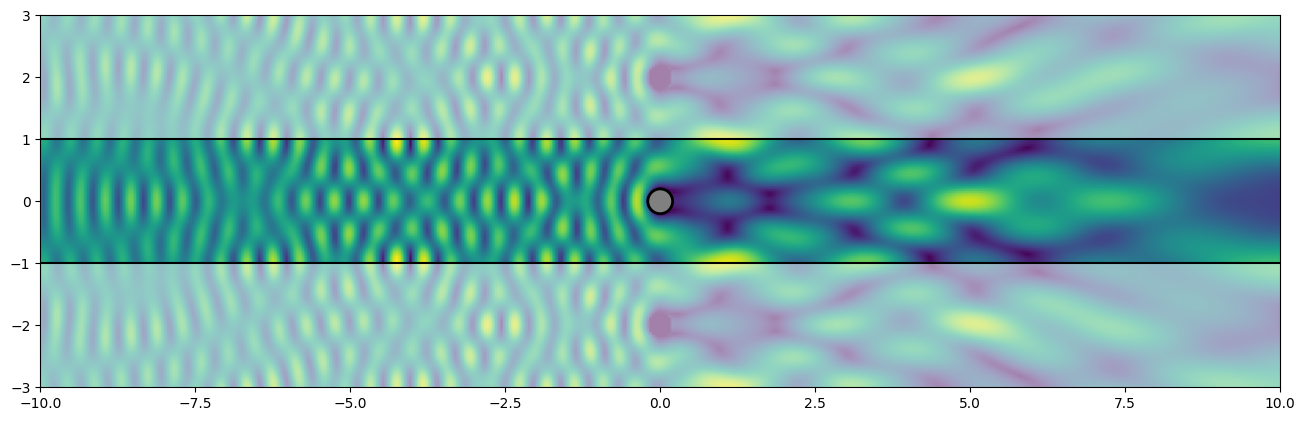

In [55]:
plt.subplots(figsize=(16,6))

u_tot = np.where(np.isnan(u),0,u+u_inc)

plt.imshow(np.abs(u_tot),origin='lower',extent=[-L,L,-H_inf,H_inf], alpha=0.5)
plt.imshow(np.abs(u_tot)[Ny//3:2*Ny//3,:],origin='lower',extent=[-L,L,-H,H])
plt.gca().add_patch(Circle(xy=(c_x,c_y),radius=R, edgecolor='k',facecolor='grey', linewidth=2))

plt.hlines([-H,H],xmin=-L,xmax=L,color='k')